## Visualize the results of the Linear Model Power analysis

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(patchwork))

In [2]:
plate <- "localhost220513100001_KK22-05-198_FactinAdjusted"  # Focus on plate 2

# Input files
lm_results_file <- file.path("results", paste0(plate, "_linear_model_cp_features.tsv"))
lm_power_file <- file.path("results", paste0(plate, "_power_analysis_cp_features_lm.tsv"))

# Output files
output_power_figure <- file.path("figures", paste0(plate, "_power_analysis_cp_lm.png"))

In [3]:
# Merge linear model results
lm_results_df <- readr::read_tsv(
    lm_results_file,
    col_types = readr::cols(.default="d", feature="c")
)
lm_power_df <- readr::read_tsv(
    lm_power_file,
    col_types = readr::cols(.default="d", feature="c")
)

# Merge for visualization
lm_data_df <- lm_results_df %>%
    dplyr::left_join(lm_power_df, by = "feature") %>%
    dplyr::arrange(estimated_sample_size) %>%
    dplyr::filter(estimated_sample_size < 100000) %>%  # Remove extreme outliers
    dplyr::filter(!is.na(power))

print(dim(lm_data_df))
head(lm_data_df)

[1] 568   9


feature,r2_score,cell_count_coef,treatment_dose_coef,u,v,sig_level,power,estimated_sample_size
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Cytoplasm_Texture_InverseDifferenceMoment_Actin_3_01_256,0.7426350,-0.0011903452,0.2973030,9,17342,8.547009e-05,0.8,29.42522
Cytoplasm_Texture_DifferenceVariance_Actin_3_01_256,0.7139563,-0.0009689702,0.2960935,9,17342,8.547009e-05,0.8,31.43152
Nuclei_Texture_AngularSecondMoment_Actin_3_01_256,0.6980765,-0.0009093237,0.2938444,9,17342,8.547009e-05,0.8,32.60615
Cells_Correlation_K_Mitochondria_Actin,0.6664501,0.0003628613,-0.2968428,9,17342,8.547009e-05,0.8,35.09949
Cytoplasm_Texture_DifferenceEntropy_Actin_3_02_256,0.6398795,0.0013159332,-0.2705772,9,17342,8.547009e-05,0.8,37.37359
Nuclei_Texture_DifferenceVariance_ER_3_01_256,0.5346176,-0.0004593783,0.2636618,9,17342,8.547009e-05,0.8,48.52707


In [4]:
# Load feature data (for calculating n)
file_suffix = "_sc_norm_fs_cellprofiler.csv.gz"
data_dir = file.path("..", "..", "..", "3.process-cfret-features", "data")
cp_file <- file.path(data_dir, paste0(plate, file_suffix))

cp_df <- readr::read_csv(
    cp_file,
    col_types = readr::cols(
        .default="d",
        Metadata_WellRow="c",
        Metadata_WellCol="c",
        Metadata_heart_number="c",
        Metadata_treatment="c",
        Metadata_dose="c",
        Metadata_Plate="c",
        Metadata_Well="c"
    )
)

n_samples <- dim(cp_df)[1]

print(dim(cp_df))
head(cp_df, 3)

[1] 17352   628


Metadata_WellRow,Metadata_WellCol,Metadata_heart_number,Metadata_treatment,Metadata_dose,Metadata_ImageNumber,Metadata_Plate,Metadata_Well,Metadata_Cytoplasm_Parent_Cells,Metadata_Cytoplasm_Parent_Nuclei,⋯,Nuclei_Texture_InverseDifferenceMoment_Mitochondria_3_01_256,Nuclei_Texture_InverseDifferenceMoment_Mitochondria_3_03_256,Nuclei_Texture_SumEntropy_ER_3_03_256,Nuclei_Texture_SumEntropy_Golgi_3_01_256,Nuclei_Texture_SumEntropy_Mitochondria_3_03_256,Nuclei_Texture_SumVariance_Actin_3_01_256,Nuclei_Texture_SumVariance_ER_3_03_256,Nuclei_Texture_SumVariance_Golgi_3_01_256,Nuclei_Texture_SumVariance_Hoechst_3_01_256,Nuclei_Texture_SumVariance_Mitochondria_3_03_256
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A,9,9,drug_x,5uM,1,localhost220513100001,A09,1,3,⋯,-1.341714,-0.7714563,0.3830138,1.5279864,1.6033489,-0.4200762,-0.2362416,0.20380578,-0.3547300,0.16163561
A,9,9,drug_x,5uM,1,localhost220513100001,A09,2,4,⋯,1.211139,0.9654590,-0.9223457,-0.4915354,-1.0004204,-0.4608149,-0.4684389,-0.20632511,-0.3310333,-0.18902928
A,9,9,drug_x,5uM,1,localhost220513100001,A09,3,7,⋯,-1.117919,-1.4119451,0.1231898,0.9340863,0.9589492,-0.4689575,-0.2375866,-0.03696811,-0.1078189,-0.06320025


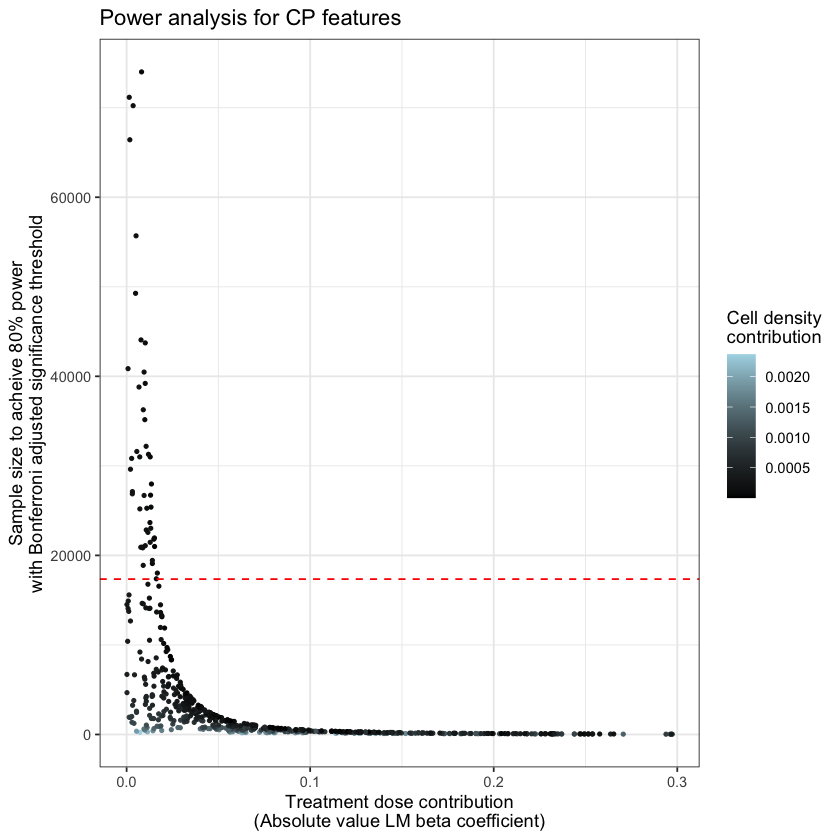

In [5]:
power_gg <- (
    ggplot(lm_data_df, aes(y = estimated_sample_size, x = abs(treatment_dose_coef)))
    + geom_point(aes(color = abs(cell_count_coef)), size = 0.8)
    + theme_bw()
    + xlab("Treatment dose contribution\n(Absolute value LM beta coefficient)")
    + ylab("Sample size to acheive 80% power\nwith Bonferroni adjusted significance threshold")
    + ggtitle("Power analysis for CP features")
    + geom_hline(yintercept = n_samples, linetype = "dashed", color = "red")
    + scale_color_gradient(name = "Cell density\ncontribution", low = "black", high = "lightblue")
)

power_gg

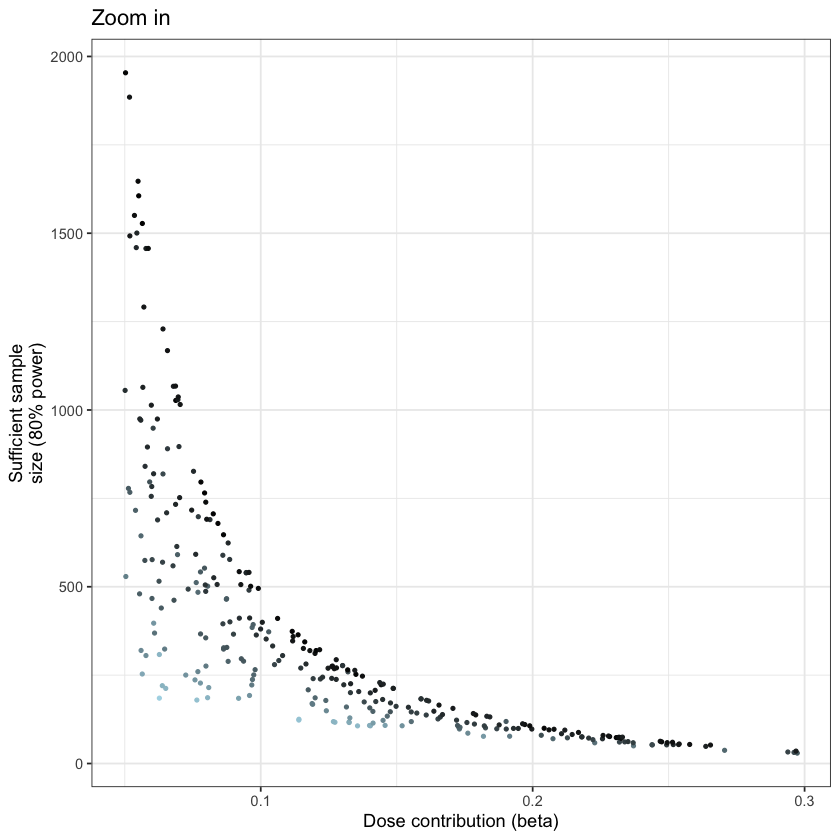

In [6]:
power_zoom_gg <- (
    ggplot(
        lm_data_df %>% dplyr::filter(abs(treatment_dose_coef) > 0.05),
        aes(y = estimated_sample_size, x = abs(treatment_dose_coef))
    )
    + geom_point(
        aes(color = abs(cell_count_coef)),
        size = 0.8,
        show.legend = FALSE
    )
    + theme_bw()
    + xlab("Dose contribution (beta)")
    + ylab("Sufficient sample\nsize (80% power)")
    + ggtitle("Zoom in")
    + scale_color_gradient(name = "Cell density\ncontribution", low = "black", high = "lightblue")
)

power_zoom_gg

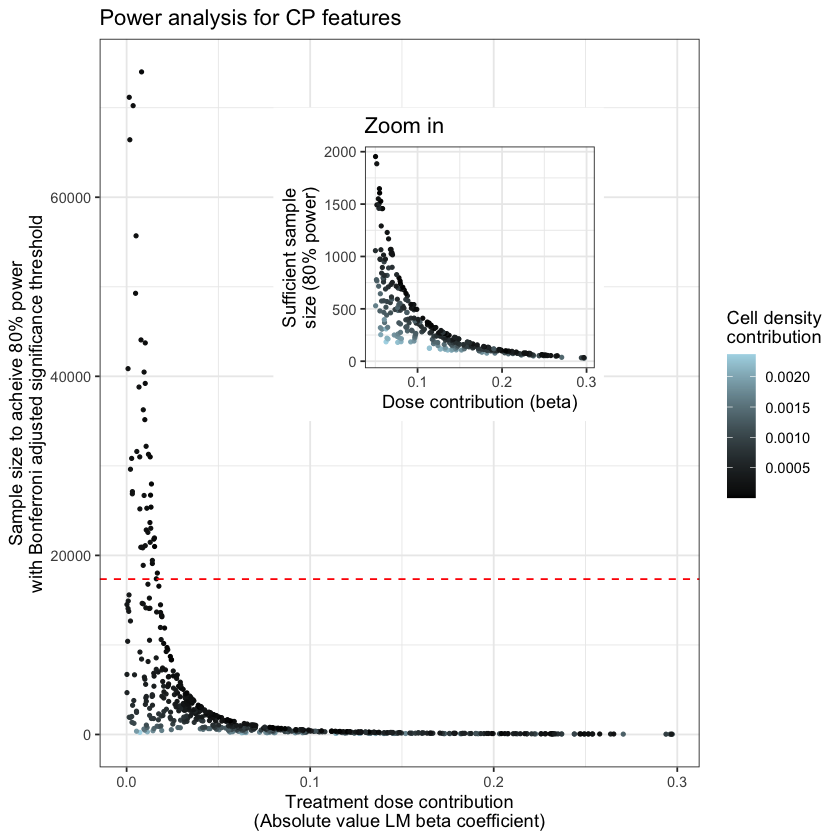

In [7]:
# Combine plots
combined_gg <- cowplot::ggdraw(
    power_gg
    + cowplot::draw_plot(
        power_zoom_gg,
        x = 0.08,
        y = 35000,
        width = .18,
        height = 35000
    )
)

ggsave(output_power_figure, combined_gg, width = 7, height = 6, dpi = 500)

combined_gg